The above header is for creating a nicely-formatted `.html` and `.pdf` documents using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html` and `.pdf` versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-31.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-31.ipynb`
- Continued from: `dissipation-theory--Study-30.ipynb`
- Continued to: `dissipation-theory--Study-32.ipynb`

# Preliminaries

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, epsilon0, qe

In [4]:
THIS = 'dissipation-theory--Study-31--'
figs = {}

# Sphere code

In [5]:
class twodimCobject():

    def __init__(self):

        pass

    def addsphere(self, r, h, Nz, Nr):
        """Model a sphere of radius $r$ above a ground plane, with a tip-sample
        separation of $h$.  Create image-charge points $r_j$ and voltage-test 
        points $r_k$.  The $N_z$ image-charge points are placed along a verical
        line extending from $h + 0.1 r$ to $h + 1.90 r$. The $N_r$ voltage-test 
        points are located uniformly around the sphere, starting at the south 
        pole, $\theta = -\pi/2$, and rotating counter clockwise. Initialize the
        values of the image charges at 1.0."""

        self.type = 'sphere'
        
        self.delta = np.linspace(start=-0.90, stop=0.90, endpoint=True, num=Nz)
        self.rj = np.array([[0, (h + r + r * delta).to('nm').magnitude] for delta in self.delta])

        self.theta = np.linspace(start=-np.pi/2, stop=3*np.pi/2, endpoint=False, num=Nr)
        self.rk = np.array([
            [(r * np.cos(theta)).to('nm').magnitude, 
             (h + r + r * np.sin(theta)).to('nm').magnitude] for theta in self.theta])
        
        # save these
        self.r = r
        self.h = h
        self.Nz = Nz
        self.Nr = Nr
        
        # for plotting, also initialize these
        self.q = np.ones(Nz)
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0
        
    def solve(self, alpha=0.):
        """Solve for the images charges.  Alpha is a parameter used to filter
        the singular values in the inverse.  In the code below, 

            $r_k$ -- voltage-test points
            $r_j$ -- image-charge points
            
        """
        
        self.alpha = alpha
        rk = self.rk
        
        # Reverse the z-coordinates to get the locations of the image charges
        rjp = self.rj
        rjm = np.array([self.rj[:,0], -self.rj[:,1]]).T

        Idk = np.ones_like(rk[:,0])
        Idj = np.ones_like(rjp[:,0])
                           
        dxp = np.outer(Idk, rjp[:,0].T) - np.outer(rk[:,0], Idj.T)
        dxm = np.outer(Idk, rjm[:,0].T) - np.outer(rk[:,0], Idj.T)
        
        dzp = np.outer(Idk, rjp[:,1].T) - np.outer(rk[:,1], Idj.T)
        dzm = np.outer(Idk, rjm[:,1].T) - np.outer(rk[:,1], Idj.T)

        R = 1.43996 * (1/np.sqrt(dxp * dxp + dzp * dzp) 
                     - 1/np.sqrt(dxm * dxm + dzm * dzm))

        U, self.S, VT = np.linalg.svd(R, full_matrices=False)

        filt = np.diag(np.power(self.S, 2)/(np.power(self.S, 2) + alpha**2))
        Sinv = filt * np.diag(np.power(self.S, -1)) 
        Rinv = np.dot(np.dot(VT.T, Sinv), U.T)

        self.R = R                               # save for later
        self.Rinv = Rinv                         # save for later
        self.q = np.dot(Rinv, np.ones(self.Nr))  # in units of qe
        self.C = 0.16022 * self.q.sum()          # in units of aF
        self.V = np.dot(R, self.q)               # in units of V
        self.dV = np.dot(R, self.q) - 1          # in units of V

        # for debugging

        self.rjp = rjp
        self.rjm = rjm
    
    def cleanup(self):
        """Set the negative image charges to zero and recompute the 
        capacitance and voltage error."""

        self.q = self.q.clip(min=0)
        self.C = 0.16022 * self.q.sum()          # in units of aF
        self.V = np.dot(self.R, self.q)          # in units of V
        self.dV = np.dot(self.R, self.q) - 1     # in units of V        
    
    def plot(self):
        """Plot, from left to right, (a) the voltage test points and the computed 
        image charges, (b) the relative voltage error around the object in parts per
        million, (c) image charge value versus position, and (d) singular values 
        for the response-function matrix."""

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8.00, 2.5))

        title = r'C = {:0.3f} aF, $\alpha$ = {:0.1e}'.format(self.C, self.alpha)
        if self.type == 'sphere':
            title = title + ', r = {:0.1f} nm, h = {:0.1f} nm'.format(
                self.r.to('nm').magnitude, 
                self.h.to('nm').magnitude)
        if self.type == 'cone':
             title = title + ', L = {:0.1f} nm, h = {:0.1f} nm'.format(
                self.L.to('nm').magnitude, 
                self.h.to('nm').magnitude)           
        fig.suptitle(title, fontsize=10)
    
        cmap = plt.get_cmap('RdBu')
        ax1.scatter(self.rj[:,0], self.rj[:,1], 
            marker='.', c=self.q, cmap=cmap, 
            alpha=0.5, edgecolors='face',
            vmin=-max(abs(self.q)), vmax=max(abs(self.q)))
        ax1.scatter(self.rk[:,0], self.rk[:,1], marker='.')
        ax1.set_xlabel(r'$\rho$ [nm]')
        ax1.set_ylabel('$z$ [nm]')
        ax1.axis('equal')
        
        ax2.plot(self.V, '.-')
        ax2.set_xlabel('index')
        ax2.set_ylabel(r'$V$ [V]')
        
        ax3.plot(self.rj[:,1], self.q, '.-')
        ax3.set_xlabel('$(r_j)_{z}$ [nm]')
        ax3.set_ylabel('$q/q_{e}$')
        ax3.set_title(r''.format(), fontsize=10)
    
        ax4.plot(self.S)
        ax4.set_xlabel('index')
        ax4.set_ylabel('singular values')
        ax4.set_yscale('log')
        
        fig.tight_layout()
        
        return fig
        

Create a two-dimensional capacitance object, add a sphere, and plot the initial guesses.

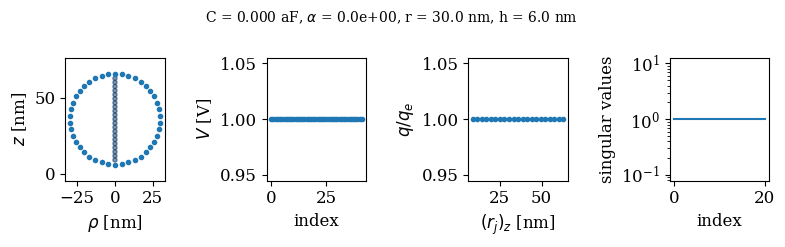

In [6]:
params = {'r': ureg.Quantity(30, 'nm'), 
          'h': ureg.Quantity(6, 'nm'), 
          'Nz': 21, 
          'Nr': 42}

obj = twodimCobject()
obj.addsphere(**params)
_ = obj.plot()

Solve for the image charges.

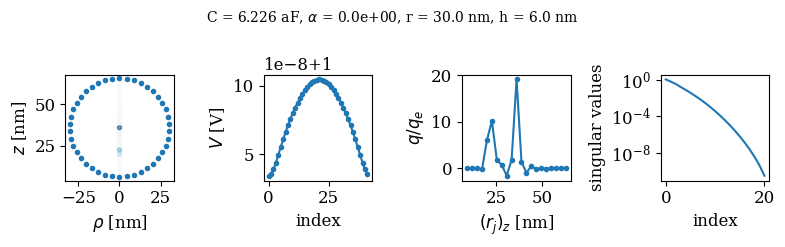

In [7]:
obj.solve()
figs['01a'] = obj.plot()

In [8]:
print("V standard deviation = {:0.2e}".format(obj.dV.std()))

V standard deviation = 2.34e-08


Setting the image charges to zero blows up the voltage error and gives the wrong capacitance!

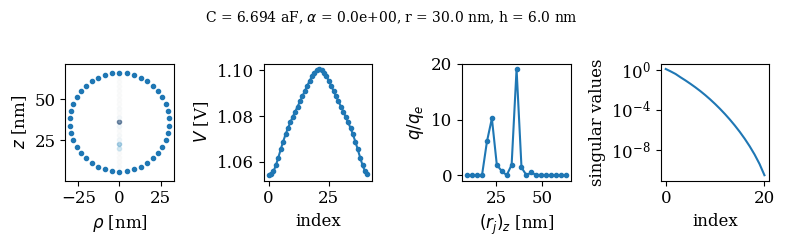

In [9]:
obj.cleanup()
figs['01b'] = obj.plot()

How bad is the voltage error?  About 1.5%.

In [10]:
print("V standard deviation = {:0.2e}".format(obj.dV.std()))

V standard deviation = 1.50e-02


How bad is the capacitance error?  About 7.5%.

In [11]:
(6.694 - 6.226)/6.226

0.07516864760681015

# Landweber iteration

The idea is to use Landwber iteration to enforce a positive image charge at every step.

Landweber maximum iteration factor

In [12]:
omega_max = 1/np.power(obj.S.max(), 2)

The voltage target and an initial quess of a uniform charge distribution.

In [13]:
V = np.ones(params['Nr'])
q0 = np.ones(params['Nz'])

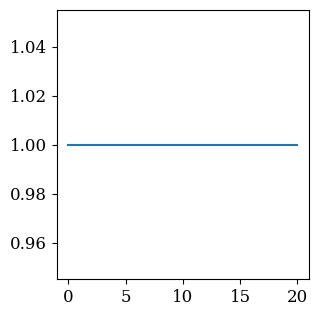

In [14]:
plt.plot(q0)
plt.show()

The voltage error for the singular value decomposition solution is very small.

In [15]:
obj.solve()
np.dot(obj.R, obj.q) - V 

array([3.43511446e-08, 3.55767746e-08, 3.89745001e-08, 4.38575134e-08,
       4.94757884e-08, 5.52650412e-08, 6.08976238e-08, 6.62188406e-08,
       7.11934702e-08, 7.58031304e-08, 8.01071092e-08, 8.40744274e-08,
       8.77748652e-08, 9.11560032e-08, 9.42417353e-08, 9.69829048e-08,
       9.93548472e-08, 1.01317544e-07, 1.02848129e-07, 1.03943947e-07,
       1.04611254e-07, 1.04836591e-07, 1.04611254e-07, 1.03943947e-07,
       1.02848130e-07, 1.01317544e-07, 9.93548475e-08, 9.69829050e-08,
       9.42417351e-08, 9.11560030e-08, 8.77748649e-08, 8.40744276e-08,
       8.01071092e-08, 7.58031304e-08, 7.11934693e-08, 6.62188404e-08,
       6.08976234e-08, 5.52650412e-08, 4.94757886e-08, 4.38575141e-08,
       3.89744996e-08, 3.55767746e-08])

The voltage error with the initial guess is huge.

In [16]:
np.dot(obj.R, q0) - V 

array([-0.01706479, -0.27036685, -0.44740937, -0.52456807, -0.55676181,
       -0.5673887 , -0.5667399 , -0.55951385, -0.5478416 , -0.53258328,
       -0.51390783, -0.49154832, -0.464893  , -0.43297411, -0.39436622,
       -0.34696409, -0.28754626, -0.21088415, -0.10773751,  0.04032156,
        0.2752851 ,  0.5521591 ,  0.2752851 ,  0.04032156, -0.10773751,
       -0.21088415, -0.28754626, -0.34696409, -0.39436622, -0.43297411,
       -0.464893  , -0.49154832, -0.51390783, -0.53258328, -0.5478416 ,
       -0.55951385, -0.5667399 , -0.5673887 , -0.55676181, -0.52456807,
       -0.44740937, -0.27036685])

Do one Landweber iteration.

In [17]:
omega = 0.5 * omega_max
q1 = q0 - omega * np.dot(obj.Rinv, np.dot(obj.R, q0) - V) 

We can see that the charge is heading in the right direction.

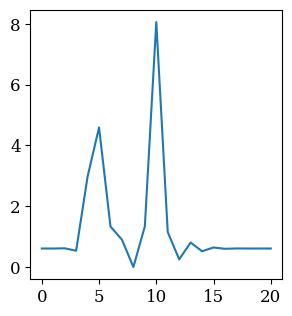

In [18]:
plt.plot(q1)
plt.show()

Do 25 Landweber iterations

In [19]:
q = q0
dV = np.dot(obj.R, q0) - V
print("V standard deviation = {:0.2e}".format(dV.std()))
for k in np.arange(25):
    q = q - omega * np.dot(obj.Rinv, dV)
    dV = np.dot(obj.R, q) - V

V standard deviation = 2.63e-01


We have reached a 2.9 ppm voltage deviation after only 25 iterations.

V standard deviation = 1.09e-06


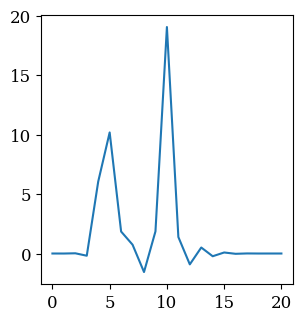

In [20]:
print("V standard deviation = {:0.2e}".format(dV.std()))
plt.plot(q)
plt.show()

Run 100 Landweber integrations

In [21]:
q = q0
dV = np.dot(obj.R, q0) - V
print("V standard deviation = {:0.2e}".format(dV.std()))
for k in np.arange(1000):
    q = q - omega * np.dot(obj.Rinv, dV)
    dV = np.dot(obj.R, q) - V

V standard deviation = 2.63e-01


The solution is even better.  It has not diverged yet.

V standard deviation = 3.23e-12


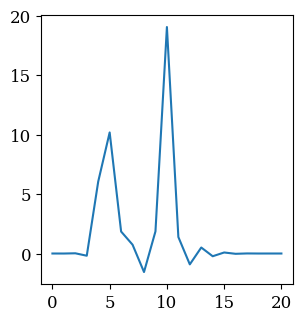

In [22]:
print("V standard deviation = {:0.2e}".format(dV.std()))
plt.plot(q)
plt.show()

Now run 25 Landweber iterations, but remove negative charges at each iteration.

In [23]:
q = q0
dV = np.dot(obj.R, q0) - V
print("V standard deviation = {:0.2e}".format(dV.std()))
for k in np.arange(25):
    q = q - omega * np.dot(obj.Rinv, dV)
    q = q.clip(min=0)
    dV = np.dot(obj.R, q) - V

V standard deviation = 2.63e-01


Now after 25 iterations, the rms voltage error is still quite large, 1.5% instead of 5 ppm.

V standard deviation = 1.50e-02


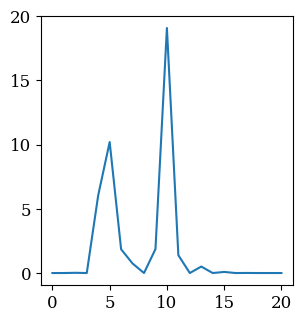

In [24]:
print("V standard deviation = {:0.2e}".format(dV.std()))
plt.plot(q)
plt.show()

Run more iterations, 100.

In [25]:
q = q0
dV = np.dot(obj.R, q0) - V
print("V standard deviation = {:0.2e}".format(dV.std()))
for k in np.arange(100):
    q = q - 0.5 * omega_max * np.dot(obj.Rinv, dV)
    q = q.clip(min=0)
    dV = np.dot(obj.R, q) - V

V standard deviation = 2.63e-01


We seem to be stuck at the sam crappy 1.5% error.

V standard deviation = 1.50e-02


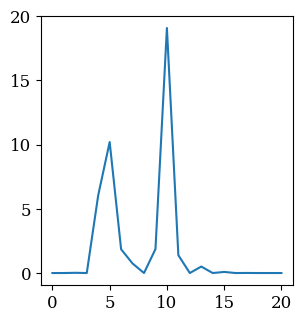

In [26]:
print("V standard deviation = {:0.2e}".format(dV.std()))
plt.plot(q)
plt.show()

Print out the capacitance.

In [27]:
print("C = {:0.3f} aF".format(0.16022 * q.sum()))

C = 6.694 aF


This result shoudl be compared to the analytical answer of 6.626 aF.  The fractional error is

In [28]:
(6.694 - 6.226)/6.226

0.07516864760681015

or about 7.5%.  This is an unacceptable level of error.

Landweber is giving me the *same answer* as just setting the negative charges to zero after solving for the charges by singular value decomposition.  Is this equality significant or just an accident?

# Cone code

In [29]:
class twodimCone(twodimCobject):
    
    def addcone(self, theta, h, L, Nz, Nr, fract=0.0):
        """Model a cone of length L and half-angle theta [degrees] above a ground plane, 
        with a tip-sample separation of $h$.  Create image-charge points $r_j$ 
        and voltage-test points $r_k$.  The $N_z$ image-charge points are placed along 
        a vertical line extending from $h$ to $h + L$. The $N_r$ voltage-test points 
        are located uniformly along the two edges of the cone.  Initialize the values
        of the image charges at 1.0."""

        self.type = 'cone'

        delta_z = np.linspace(start=0, stop=1, endpoint=True, num=Nz+1)[1:]
        self.rj = np.array([[0, (h + L * delta).to('nm').magnitude] for delta in delta_z])

        Nhalf = int((Nr-1)/2)
        delta_L = np.linspace(start=1, stop=0, endpoint=True, num=Nhalf+1)[0:-1]
        delta_R = np.linspace(start=0, stop=1, endpoint=True, num=Nhalf+1)[1:]

        # perturb by (fract) of step size
        dd = np.abs(delta_L[1] - delta_L[0])
        delta_L = delta_L + np.random.normal(0, fract * dd, len(delta_L))
        delta_R = delta_R + np.random.normal(0, fract * dd, len(delta_L))
        
        rk_L = np.array([
            [(   -L * delta * np.tan(np.radians(theta))).to('nm').magnitude, 
             (h + L * delta).to('nm').magnitude] for delta in delta_L])
        rk_C = np.array([[0, h.to('nm').magnitude]])
        rk_R = np.array([
            [(    L * delta * np.tan(np.radians(theta))).to('nm').magnitude, 
             (h + L * delta).to('nm').magnitude] for delta in delta_R])

        self.rk = np.concatenate((rk_L, rk_C, rk_R), axis=0)

        self.q = np.ones(Nz)
        
        # save these
        self.h = h
        self.L = L
        self.Nz = Nz
        self.Nr = Nr
        
        # for plotting, also initialize these
        self.q = np.ones(Nz)
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0

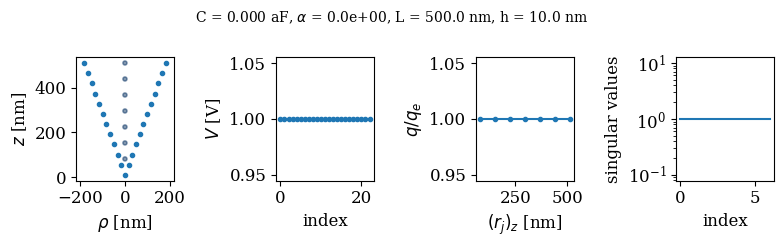

In [30]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 7, 
          'Nr': 23}

obj = twodimCone()
obj.addcone(**params)
_ = obj.plot()

Confirm that we get the number of points we expect.

In [31]:
(len(obj.rj), len(obj.rk))

(7, 23)

Add more points and try to solve.

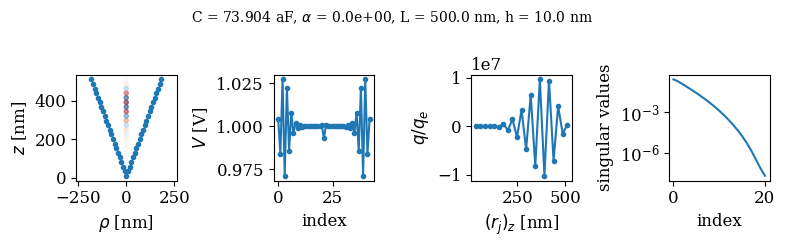

In [32]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43}

obj = twodimCone()
obj.addcone(**params)
obj.solve()
_ = obj.plot()

Well this is disappointing!  The voltage is close to 1, but why are the charges oscillating so much?

In [33]:
obj.q

array([ 3.05633897e+02, -3.30961013e+03,  1.55058728e+04, -4.87730817e+04,
        1.21527903e+05, -2.59469892e+05,  4.96408545e+05, -8.74425436e+05,
        1.44324572e+06, -2.25655695e+06,  3.36222490e+06, -4.77960362e+06,
        6.45694175e+06, -8.20735706e+06,  9.64903810e+06, -1.02245988e+07,
        9.41106475e+06, -7.13737219e+06,  4.12039653e+06, -1.58248410e+06,
        2.97752329e+05])

Try perturbing the boundary points by 20 percent.

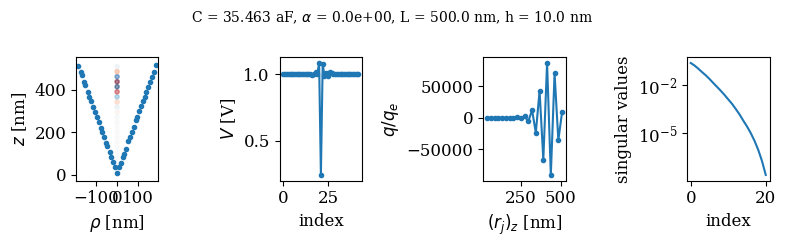

In [34]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43,
          'fract': 0.20}

obj = twodimCone()
obj.addcone(**params)
obj.solve()
_ = obj.plot()

Perturbing the location of the boundary points does not help convergence.  We are still seeing wild oscillations in the charge along the centerline.

Go back to using regularly spaced boundary points.  Try adjusting $\alpha$, the SVD filtering parameter. 

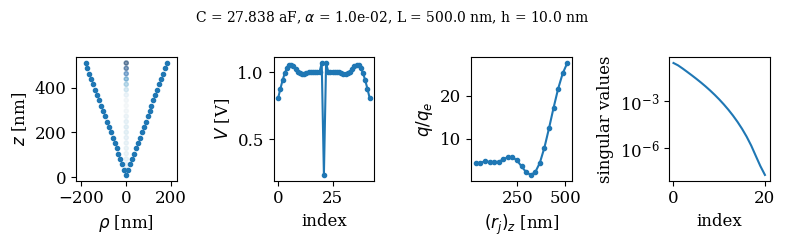

In [35]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43}

obj = twodimCone()
obj.addcone(**params)
obj.solve(alpha=1e-2)
_ = obj.plot()

With a very agressive filtering parameter, $\alpha = 0.01$, the image charges are now all the same sign. However, the errors in voltage are 70% near the tip.

Try a somewhat less agressive filtering parameter $\alpha$.

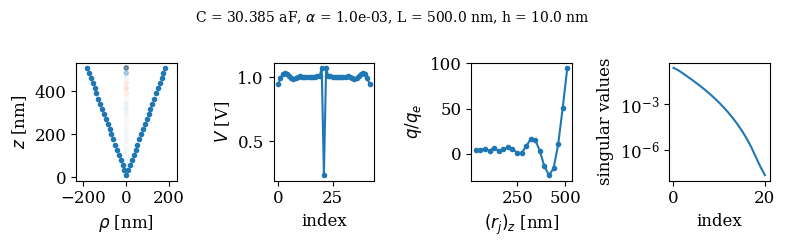

In [36]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43}

obj = twodimCone()
obj.addcone(**params)
obj.solve(alpha=1e-3)
_ = obj.plot()

The charges now go negative far away from the tip, although the voltage error is less, except near the tip.

In [37]:
obj.q

array([  4.19956809,   4.14324195,   5.23433617,   3.23339605,
         6.59498058,   2.83986652,   4.84809629,   6.94521378,
         5.41534032,   0.9300637 ,   0.83639012,   8.17053456,
        16.21929212,  15.40044669,   2.9383171 , -14.13641866,
       -23.74004603, -16.29261864,  10.30190806,  50.55119097,
        95.01472607])

Near the tip, the image charge density is approaching a constant.

Convert the image charge to an image-charge *density*.

In [38]:
def charge_density(obj):
    dz = ureg.Quantity(abs(obj.rk[1]-obj.rk[0])[1], 'nm')
    lambduh = ureg.Quantity(qe * obj.q / dz, 'C/m')  
    return lambduh

In [39]:
charge_density(obj).to('pC/m').magnitude

array([  28.25948937,   27.88046279,   35.22259058,   21.75798064,
         44.37855979,   19.10986464,   32.62352762,   46.73532869,
         36.44059315,    6.25853059,    5.62818777,   54.98068601,
        109.14191735,  103.63179027,   19.77235256,  -95.12596637,
       -159.75013713, -109.63534188,   69.32300064,  340.16613451,
        639.36756921])

Compute the line-charge density for a cone of half angle $\theta$.

In [40]:
def charge_density_calc(params):

    beta = np.log((1 + np.cos(np.radians(params['theta'])))/
                  (1 - np.cos(np.radians(params['theta']))))
    return 4 * np.pi * epsilon0 * ureg.Quantity(1, 'V') / beta

In [41]:
charge_density_calc(params).to('pC/m').magnitude

32.05717223700887

This should be compared to the "observed" 28.2 pC/m. \
The "observed" line-charge density is about 13 percent smaller than the calculated line-charge density.

Compute the capacitance for a cone of length $L$ very near a ground plane.

In [42]:
def cone_capacitance_calc(params):

    beta = np.log((1 + np.cos(np.radians(params['theta'])))/
              (1 - np.cos(np.radians(params['theta']))))
    return 4 * np.pi * epsilon0 * params['L'] / beta

In [43]:
cone_capacitance_calc(params).to('aF')

<Quantity(16.028586118504432, 'attofarad')>

This should be compared to the "observed" 30.4 aF. \
The "observed" capacitance is nearly 2-fold larger than the calculated capacitance.

# Conclusions so far

The calculation of the capacitance of an "open" cone is not giving sensible results.  What to try next?  In contrast with the cone problem, solving for the image charges of a circle gave sensible results.  Maybe the problem is that the cone, as constructed, is not a *closed* domain. 

1. Might adding a *top* to the cone help?
2. If that fails, press onward with a half-sphere plus a cone.

# Cone with flat top

Add a top to the cone.  Don't worry about getting the number of points Nr equal to what the use wants.  Do try to make the linear spacing between the points approximately the same on the top as for the sides. 

In [44]:
class twodimCone(twodimCobject):
    
    def addcone(self, theta, h, L, Nz, Nr, fract=0.0):
        """Model a cone of length L and half-angle theta [degrees] above a ground plane, 
        with a tip-sample separation of $h$.  Create image-charge points $r_j$ 
        and voltage-test points $r_k$.  The $N_z$ image-charge points are placed along 
        a vertical line extending from $h$ to $h + L$. The $N_r$ voltage-test points 
        are located uniformly along the two edges of the cone.  Initialize the values
        of the image charges at 1.0."""

        self.type = 'cone'

        delta_z = np.linspace(start=0, stop=1, endpoint=True, num=Nz+1)[1:]
        self.rj = np.array([[0, (h + L * delta).to('nm').magnitude] for delta in delta_z])

        Nhalf = int((Nr-1)/2)
        delta_L = np.linspace(start=1, stop=0, endpoint=True, num=Nhalf+1)[0:-1]
        delta_R = np.linspace(start=0, stop=1, endpoint=True, num=Nhalf+1)[1:]

        # perturb by (fract) of step size
        dd = np.linalg.norm(delta_L[1] - delta_L[0])
        delta_L = delta_L + np.random.normal(0, fract * dd, len(delta_L))
        delta_R = delta_R + np.random.normal(0, fract * dd, len(delta_L))

        # sides
        rk_L = np.array([
            [(   -L * delta * np.tan(np.radians(theta))).to('nm').magnitude, 
             (h + L * delta).to('nm').magnitude] for delta in delta_L])
        rk_C = np.array([[0, h.to('nm').magnitude]])
        rk_R = np.array([
            [(    L * delta * np.tan(np.radians(theta))).to('nm').magnitude, 
             (h + L * delta).to('nm').magnitude] for delta in delta_R])

        # top
        step = ureg.Quantity(np.linalg.norm(rk_L[1] - rk_L[0]), 'nm')
        half_width = L * np.tan(np.radians(theta))
        Ntop = int((2 * half_width / step).to('').magnitude)
        delta_T = np.linspace(start=1, stop=-1, endpoint=True, num=Ntop+2)[1:-1]
        rk_T = np.array([
            [(delta * half_width).to('nm').magnitude,
             (h + L).to('nm').magnitude] for delta in delta_T])
        
        self.rk = np.concatenate((rk_L, rk_C, rk_R, rk_T), axis=0)
        Nr = len(self.rk)
        
        self.q = np.ones(Nz)
        
        # save these
        self.h = h
        self.L = L
        self.Nz = Nz
        self.Nr = Nr
        
        # for plotting, also initialize these
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0

Just adding a top to the code does not immediately solve the charge-divergence problem.

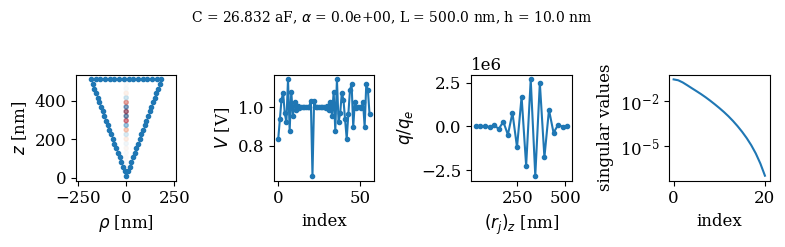

In [45]:
params = {'theta': 20., 
          'L': ureg.Quantity(500, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43}

obj = twodimCone()
obj.addcone(**params)
obj.solve()
_ = obj.plot()

Try some agressive filtering.  Adjust the filter parameter `alpha` manually to keep the image charges all positive.

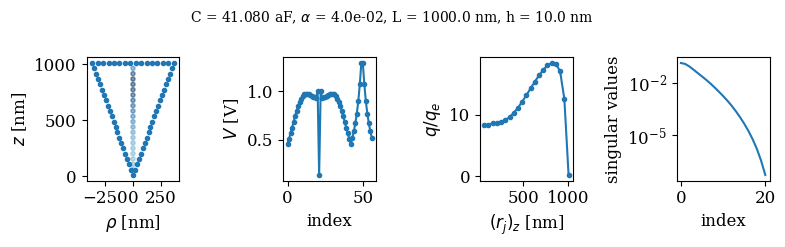

In [46]:
params = {'theta': 20., 
          'L': ureg.Quantity(1000, 'nm'), 
          'h': ureg.Quantity(10, 'nm'), 
          'Nz': 21, 
          'Nr': 43}

obj = twodimCone()
obj.addcone(**params)
obj.solve(alpha=4e-2)
_ = obj.plot()

The expected cone capacitance is

In [47]:
cone_capacitance_calc(params).to('aF')

<Quantity(32.057172237008864, 'attofarad')>

Compare the observed charge line density to the expected charge line density.

In [48]:
charge_density(obj).to('pC/m').magnitude

array([27.9286243 , 28.31281823, 28.96125164, 29.16661995, 29.67166474,
       30.72224171, 32.40031534, 34.69923342, 37.54946458, 40.83632891,
       44.41503792, 48.12299715, 51.78847515, 55.23356953, 58.2663885 ,
       60.64965266, 62.01113367, 61.58835513, 57.38225541, 42.23450216,
        0.73666262])

In [49]:
charge_density_calc(params).to('pC/m').magnitude

32.05717223700887

With an agressive filtering parameter $\alpha$, 

* we are approaching the expected line-charge density at the leading edge and
* the charge density at the top cap is tending to zero.

So overall, the charge density is somewhat more sensible.  The surface potential, however, shows huge deviations from 1 V.  The surface potential near the leading edge is close to 1 V, except the lowest three points.  Capping the tip with a cone will, I hope, tame this divergence.  

Idea: Cap the cone at both the top *and* the bottom with a half sphere.

# Cone capped with spheres (try 1)

In [50]:
class cappedCone(twodimCobject):
    
    def addcone(self, h, r, L, theta, Nr, Nz):

        self.type = 'capped cone'

        # save these
        
        self.h = h
        self.r = r
        self.L = L
        self.theta = theta
        self.Nz = Nz
        self.Nr = Nr
        
        # strip units for subsequent calculations
        
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude
        L = L.to('nm').magnitude

        # make angle radians for subsequent calculations
        
        theta = np.radians(theta)

        # lengths of each segment
        
        R = r + L * np.tan(theta)

        L1 = 0.5 * np.pi * R
        L2 = L / np.cos(theta)
        L3 = np.pi * r
        L4 = L / np.cos(theta)
        L5 = 0.5 * np.pi * R
        
        length = L1 + L2 + L3 + L4 + L5

        # numner of points in each segment
        
        N1 = int(Nr * L1 / length)
        N2 = int(Nr * L2 / length)
        N3 = int(Nr * L3 / length)
        N4 = int(Nr * L4 / length)      
        N5 = int(Nr * L5 / length)
        
        # image charge locations
        
        delta_z = np.linspace(start=0.05, stop=0.95, endpoint=True, num=Nz)
        self.rj = np.array([[0, h + (r + L + R) * delta] for delta in delta_z])

        # field-test point locations

        t1 = np.linspace(start=np.pi/2, stop=0, num=N1)
        t2 = np.linspace(start=1, stop=0, num = N2)
        t3 = np.linspace(start=0, stop=-np.pi, num=N3)
        t4 = np.linspace(start=0, stop=1, num = N4)
        t5 = np.linspace(start=np.pi, stop=np.pi/2, num=N5)
        
        rk1 = np.array([[R * np.cos(t), h + r + L + R * np.sin(t)] for t in t1])
        rk2 = np.array([[ r + L * np.tan(theta) * t, h + r + L * t] for t in t2])
        rk3 = np.array([[r * np.cos(t), h + r + r * np.sin(t)] for t in t3])
        rk4 = np.array([[-r + L * np.tan(-theta) * t, h + r + L * t] for t in t2])
        rk5 = np.array([[R * np.cos(t), h + r + L + R * np.sin(t)] for t in t5])

        if N2 == 0:
            self.rk = np.concatenate((rk1, rk3, rk5), axis=0)
        else:
            self.rk = np.concatenate((rk1, rk2, rk3, rk4, rk5), axis=0)
        
        # save these

        self.Nr = len(self.rk)
        self.length = length
        
        # for plotting, also initialize these
        self.q = np.ones(Nz)
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0

First, a control experiment.  Compare the capped cone with a sphere.  Set the cone length to zero.  For the comparison to be exact, it is important that `Nr` be divisible by 5, since we are breaking the capped cone to five segments.  Otherwise, the actual `Nr` will not come out to be the desired number.  Moreoever, the number of points in the top and bottom segments might not be the same, breaking symmetry.

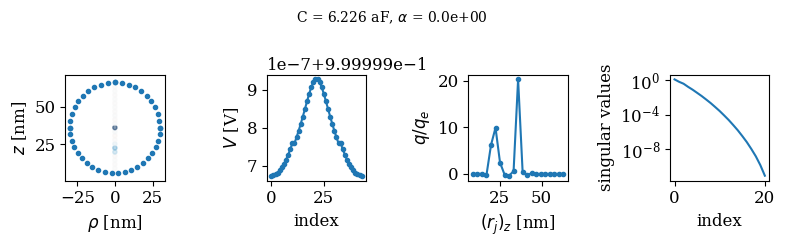

In [51]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(0, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

obj1 = cappedCone()
obj1.addcone(**params)
obj1.solve()
_ = obj1.plot()

In [52]:
(obj1.Nr, obj1.Nz)

(44, 21)

Compare to an simple sphere.

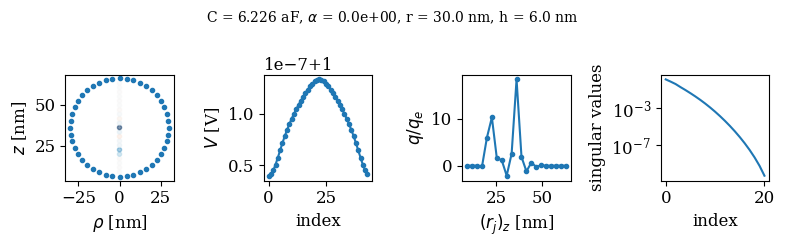

In [53]:
params = {'h': ureg.Quantity(6, 'nm'),
          'r': ureg.Quantity(30, 'nm'),  
          'Nz': 21, 
          'Nr': 44}

obj2 = twodimCobject()
obj2.addsphere(**params)
obj2.solve()
_ = obj2.plot()

In [54]:
(obj1.Nr, obj1.Nz)

(44, 21)

Check that the image-charge *locations* are exactly the same.

In [55]:
np.all((np.isclose(obj1.rj,obj2.rj)).flatten())

True

Plot the difference in the charge distributions.

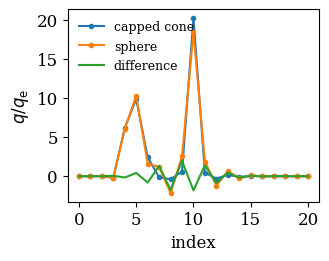

In [56]:
fig = plt.figure(figsize=(3.25, 2.5))
plt.plot(obj1.q, '.-', label='capped cone')
plt.plot(obj2.q, '.-', label='sphere')
plt.plot(obj2.q - obj1.q, label='difference')
plt.legend(fontsize=9, frameon=False, loc=2)
plt.xlabel('index')
plt.ylabel(r'$q/q_{\mathrm{e}}$')
plt.show()

The capacitances are the same to three significant figures, but the charge distributions are visibly different. The two distributions have charge densities that differ by approximately 10 percent.  Why is the charge distribution slightly *better* in the capped-cone case, with essentially no negative image charges present?  

Look at the voltage-test points.

In [57]:
def testtwospheres(obj1, obj2, note1, note2):
    
    r1 = np.sqrt((obj1.rk[:,0] - obj1.rk[:,0].mean())**2 + (obj1.rk[:,1] - obj1.rk[:,1].mean())**2)
    r2 = np.sqrt((obj2.rk[:,0] - obj2.rk[:,0].mean())**2 + (obj2.rk[:,1] - obj2.rk[:,1].mean())**2)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.50, 2.5))
    
    ax1.plot(r1, '.-', label='obj1' + ' ' + note1)
    ax1.plot(r2, '-', label='obj2' + ' ' + note2)
    ax1.legend(fontsize=9, frameon=False)
    ax1.set_xlabel('index $k$')
    ax1.set_ylabel(r'$r_k$')

    ax2.plot(obj1.rk[:,0], '.-', label='obj1')
    ax2.plot(obj2.rk[:,0], '-', label='obj2')
    ax2.legend(fontsize=9, frameon=False, loc=3)
    ax2.set_xlabel('index $k$')
    ax2.set_ylabel(r'($r_{k})_{x}$')

    ax3.plot(obj1.rk[:,1], '.-', label='obj1')
    ax3.plot(obj2.rk[:,1], '-', label='obj2')
    ax3.legend(fontsize=9, frameon=False, loc=3)
    ax3.set_xlabel('index $k$')
    ax3.set_ylabel(r'($r_{k})_{y}$')
    
    fig.tight_layout()
    return fig


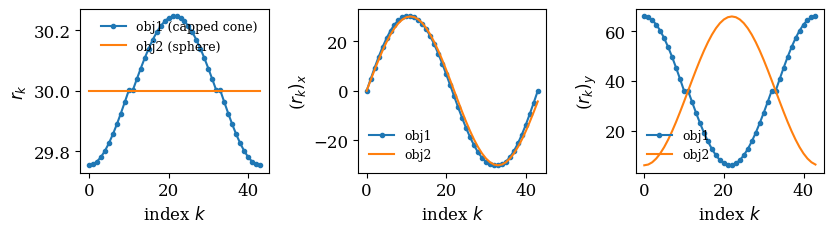

In [58]:
_ = testtwospheres(obj1, obj2, '(capped cone)', '(sphere)')

Conclude that the voltage test points *not* exactly the same in the two objects.

Having a slighly non-spherical set of test points may actually *help* you obtain a better solution for the image charges.

# Cone capped with spheres (try 2)

So the $r_k$ points agree with the sphere, have the $r_k$ points start at the south pole and rotate counterclockwise.

In [59]:
class cappedCone(twodimCobject):
    
    def addcone(self, h, r, L, theta, Nr, Nz, ecc=0.00):

        self.type = 'capped cone'

        # save these
        
        self.h = h
        self.r = r
        self.L = L
        self.theta = theta
        self.Nz = Nz
        self.Nr = Nr
        
        # strip units for subsequent calculations
        
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude
        L = L.to('nm').magnitude

        # make angle radians for subsequent calculations
        
        theta = np.radians(theta)

        # lengths of each segment
        
        R = r + L * np.tan(theta)

        L1 = 0.5 * np.pi * r
        L2 = L / np.cos(theta)
        L3 = np.pi * R
        L4 = L / np.cos(theta)
        L5 = 0.5 * np.pi * r
        
        length = L1 + L2 + L3 + L4 + L5

        # numner of points in each segment
        
        N1 = int(Nr * L1 / length)
        N2 = int(Nr * L2 / length)
        N3 = int(Nr * L3 / length)
        N4 = int(Nr * L4 / length)      
        N5 = int(Nr * L5 / length)
        
        # image charge locations
        
        delta_z = np.linspace(start=0.05, stop=0.95, endpoint=True, num=Nz)
        self.rj = np.array([[0, h + (r + L + R) * delta] for delta in delta_z])

        # field-test point locations

        t1 = np.linspace(start=-np.pi/2, stop=0, endpoint=False, num=N1)
        # t2 = np.linspace(start=1, stop=0, num = N2)
        t3 = np.linspace(start=0, stop=np.pi, endpoint=False, num=N3)
        # t4 = np.linspace(start=0, stop=1, num = N4)
        t5 = np.linspace(start=np.pi, stop=3*np.pi/2, endpoint=False, num=N5)
        
        rk1 = np.array([[r * np.cos(t), h + r + (1 + ecc) * r * np.sin(t)] for t in t1])
        # rk2 = np.array([[ r + L * np.tan(theta) * t, h + r + L * t] for t in t2])
        rk3 = np.array([[R * np.cos(t), h + r + (1 + ecc) * R * np.sin(t)] for t in t3])
        # rk4 = np.array([[-r + L * np.tan(-theta) * t, h + r + L * t] for t in t2])
        rk5 = np.array([[r * np.cos(t), h + r + (1 + ecc) * r * np.sin(t)] for t in t5])

        # print(rk1[0], rk1[-1], rk3[0], rk3[-1], rk5[0], rk5[-1])
        
        self.rk = np.concatenate((rk1, rk3, rk5), axis=0)
        
        # if N2 == 0:
        #     self.rk = np.concatenate((rk1, rk3, rk5), axis=0)
        # else:
        #     self.rk = np.concatenate((rk1, rk2, rk3, rk4, rk5), axis=0)
        
        # save these

        self.Nr = len(self.rk)
        self.length = length
        
        # for plotting, also initialize these
        self.q = np.ones(Nz)
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0

Edit the above code until the two spheres agree.

(21, 44)

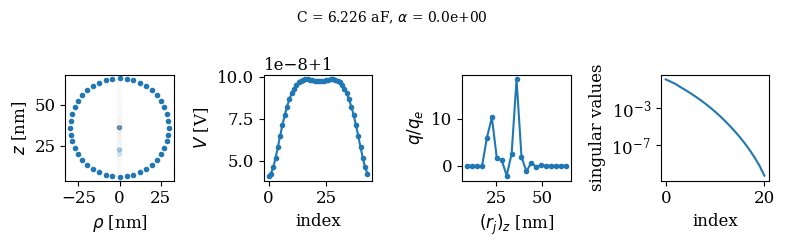

In [60]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(0, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

obj1 = cappedCone()
obj1.addcone(**params)
obj1.solve()
_ = obj1.plot()

(obj1.Nz, obj1.Nr)

(21, 44)

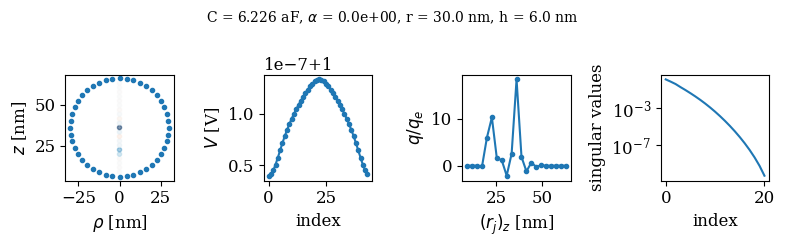

In [61]:
params = {'h': ureg.Quantity(6, 'nm'),
          'r': ureg.Quantity(30, 'nm'),  
          'Nz': 21, 
          'Nr': 44}

obj2 = twodimCobject()
obj2.addsphere(**params)
obj2.solve()
_ = obj2.plot()

(obj2.Nz, obj2.Nr)

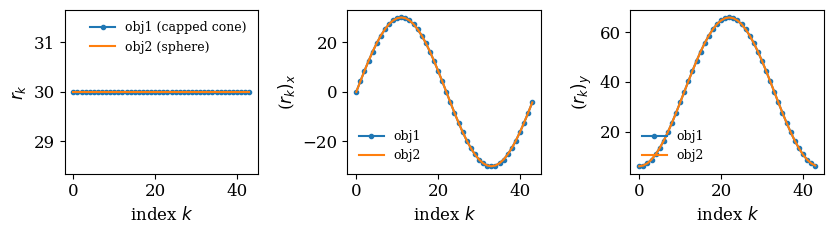

In [62]:
_ = testtwospheres(obj1, obj2, '(capped cone)', '(sphere)')

Check that all the image-charge locations are the same.

In [63]:
np.all((np.isclose(obj1.rj,obj2.rj,rtol=1e-12)).flatten())

True

Check that all the voltage-test points are the same.

In [64]:
np.all((np.isclose(obj1.rk,obj2.rk,rtol=1e-12)).flatten())

True

What about the charges?

In [65]:
np.all((np.isclose(obj1.q,obj2.q,rtol=1e-05)).flatten())

True

What about the voltages?

In [66]:
np.all((np.isclose(obj1.V,obj2.V,rtol=1e-07)).flatten())

True

So why are the charges and the voltages *slightly* different? 

I think it because this an ill-posed problem.  You can tell this because the condition number of the singular value decomposition is very large.

In [67]:
def cn(obj, verbose=True):
    cn = max(obj.S)/min(obj.S)
    if verbose:
        print("condition number = {:0.2e}".format(cn))
    return(cn)

In [68]:
_ = cn(obj1)

condition number = 2.12e+10


I played with adding random numbers to the `obj1.rj` and `obj1.rk` values, but the solution does not improve.  

Adding a little *eccentricity* to the circle does not improve the condition number or the solution.

condition number = 2.10e+10


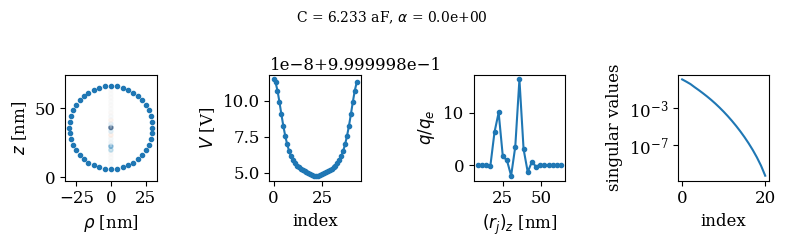

In [69]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(0, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44,
          'ecc': 0.001}

obj3 = cappedCone()
obj3.addcone(**params)
obj3.solve()
_ = obj3.plot()
_ = cn(obj3)

# Cone capped with spheres (try 3)

Now add the sloped sidewalls back in.

In [70]:
class cappedCone(twodimCobject):
    
    def addcone(self, h, r, L, theta, Nr, Nz):

        self.type = 'capped cone'

        # save these
        
        self.h = h
        self.r = r
        self.L = L
        self.theta = theta
        self.Nz = Nz
        self.Nr = Nr
        
        # strip units for subsequent calculations
        
        h = h.to('nm').magnitude
        r = r.to('nm').magnitude
        L = L.to('nm').magnitude

        # make angle radians for subsequent calculations
        
        theta = np.radians(theta)

        # lengths of each segment
        
        R = r + L * np.tan(theta)

        L1 = 0.5 * np.pi * r
        L2 = L / np.cos(theta)
        L3 = np.pi * R
        L4 = L / np.cos(theta)
        L5 = 0.5 * np.pi * r
        
        length = L1 + L2 + L3 + L4 + L5

        # numner of points in each segment
        
        N1 = int(Nr * L1 / length)
        N2 = int(Nr * L2 / length)
        N3 = int(Nr * L3 / length)
        N4 = int(Nr * L4 / length)      
        N5 = int(Nr * L5 / length)
        
        # image charge locations
        
        delta_z = np.linspace(start=0.05, stop=0.95, endpoint=True, num=Nz)
        self.rj = np.array([[0, h + (r + L + R) * delta] for delta in delta_z])

        # field-test point locations

        t1 = np.linspace(start=-np.pi/2, stop=0, endpoint=False, num=N1)
        t2 = np.linspace(start=0, stop=1, endpoint=False, num = N2)
        t3 = np.linspace(start=0, stop=np.pi, endpoint=False, num=N3)
        t4 = np.linspace(start=0, stop=1, endpoint=False, num = N4)
        t5 = np.linspace(start=np.pi, stop=3*np.pi/2, endpoint=False, num=N5)
        
        rk1 = np.array([[r * np.cos(t), h + r + r * np.sin(t)] for t in t1])
        rk2 = np.array([[ r + L * np.tan( theta) * t, h + r + L * t] for t in t2])
        rk3 = np.array([[R * np.cos(t), L + h + r + R * np.sin(t)] for t in t3])
        rk4 = np.array([[-r + L * np.tan(-theta) * (1 - t), h + r + L * (1 - t)] for t in t4])
        rk5 = np.array([[r * np.cos(t), h + r + r * np.sin(t)] for t in t5])

        
        
        if N2 == 0:
            self.rk = np.concatenate((rk1, rk3, rk5), axis=0)
            # print(rk1[0], rk1[-1], rk3[0], rk3[-1], rk5[0], rk5[-1])
        else:
            self.rk = np.concatenate((rk1, rk2, rk3, rk4, rk5), axis=0)
            # print(rk1[0], rk1[-1], rk2[0], rk2[-1], rk3[0], rk3[-1], rk4[0], rk4[-1], rk5[0], rk5[-1])
        
        # save these

        self.Nr = len(self.rk)
        self.length = length
        
        # for plotting, also initialize these
        self.q = np.ones(Nz)
        self.S = np.ones(Nz)
        self.V = np.ones(Nr)
        self.dV = -1 * np.ones(Nr)
        self.C = 0
        self.alpha = 0

Show that we reproduce prior calculations when $L = 0$ (the sphere limit).

condition number = 2.12e+10


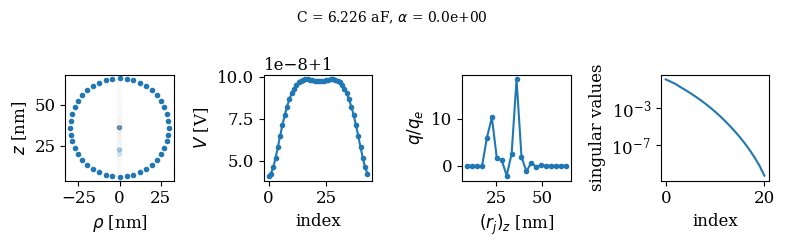

In [71]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(0, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

obj1 = cappedCone()
obj1.addcone(**params)
obj1.solve()
_ = obj1.plot()
_ = cn(obj1)

Now try a cone.  Set the cone angle to zero but make $L$ nonzero.

condition number = 8.04e+10


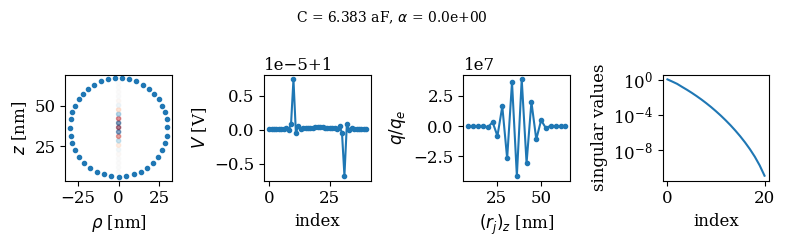

In [72]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(1, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

obj1 = cappedCone()
obj1.addcone(**params)
obj1.solve()
_ = obj1.plot()
_ = cn(obj1)

Setting $L = 1$ nm is enough to increase the condition number by a factor of 4 and give non-sensical image charges.  Vary the length $L$ and at each $L$ determine the condition number.

In [73]:
L_array = np.linspace(start=0, stop=30, num=200)
cn_array = np.zeros_like(L_array)

for index, L in enumerate(L_array):

    params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(L, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

    obj1 = cappedCone()
    obj1.addcone(**params)
    obj1.solve()
    cn_array[index] = cn(obj1, verbose=False)

Plot the condition number versus $L$.  We see oscillations.

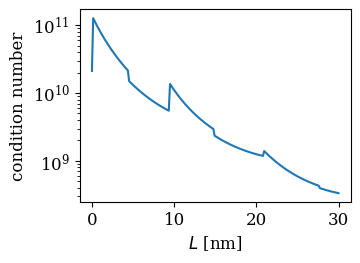

In [74]:
fig = plt.figure(figsize=(3.50, 2.5))
plt.semilogy(L_array, cn_array)
plt.xlabel('$L$ [nm]')
plt.ylabel('condition number')
plt.show()

Just because the condition number is low, however, does not mean the solution is sensible.  See the following example.

condition number = 3.35e+08


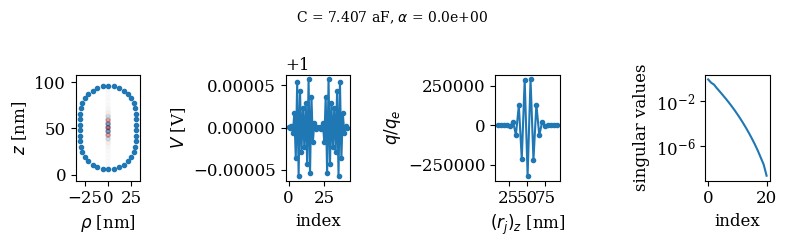

In [75]:
params = {'h': ureg.Quantity(6,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(30, 'nm'), 
          'theta': 0.,
          'Nz': 21, 
          'Nr': 44}

obj2 = cappedCone()
obj2.addcone(**params)
obj2.solve()
_ = obj2.plot()
_ = cn(obj2)

Set up a short cone, and play with the number of image-charge points and $\alpha$.

In [76]:
def zstep(obj, verbose=True):
    zstep = obj.rj[1,1] - obj.rj[0,1]
    if verbose:
        print("z step = {:0.1f} nm".format(zstep))
    return zstep

In [77]:
def go(params, alpha):

    obj = cappedCone()
    obj.addcone(**params)
    obj.solve(alpha)
    fig = obj.plot()
    _ = cn(obj)
    _ = zstep(obj)

    return fig, obj

Keep the number of image-charge points modest, and increase $\alpha$ manually until

1. the voltage variation is not too bad and 
2. the image charge is (almost) always positive.

condition number = 5.43e+07
z step = 6.4 nm


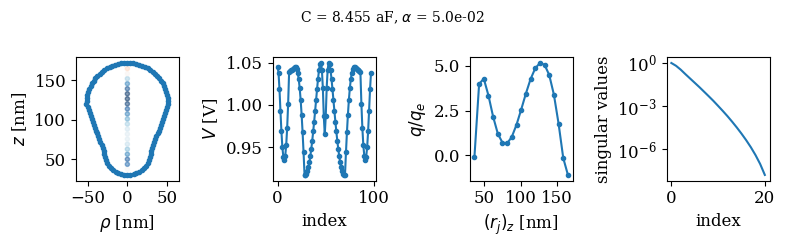

In [78]:
params3 = {'h': ureg.Quantity(30,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(60, 'nm'), 
          'theta': 20.,
          'Nz': 21, 
          'Nr': 100}

_, obj3 = go(params3, 5e-2)

Now increase the number of points.  As you increase the number of image-charge points, you also have to increase $\alpha$.

condition number = 2.43e+16
z step = 2.6 nm


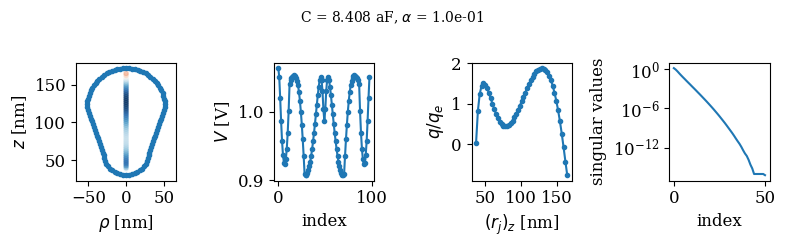

In [79]:
params4 = {'h': ureg.Quantity(30,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(60, 'nm'), 
          'theta': 20.,
          'Nz': 51, 
          'Nr': 100}

_, obj4 = go(params4, 10e-2)

Now decrease the number of points.

condition number = 5.83e+03
z step = 12.8 nm


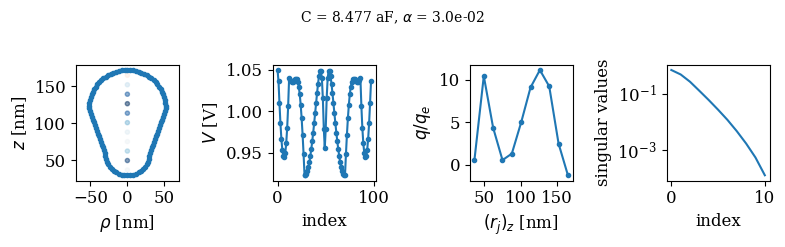

In [80]:
params5 = {'h': ureg.Quantity(30,   'nm'),
          'r': ureg.Quantity(30,  'nm'),
          'L': ureg.Quantity(60, 'nm'), 
          'theta': 20.,
          'Nz': 11, 
          'Nr': 100}

_, obj5 = go(params5, 3e-2)

A helpful function.

In [81]:
def chargereport(params, obj):

    r = params['r'].to('nm').magnitude
    h = params['h'].to('nm').magnitude
    
    pre = 4 * np.pi * epsilon0 * ureg.Quantity(1, 'volt') / qe
    q_calc = (pre * params['r']).to('').magnitude

    mask = np.logical_and(
        obj.rj[:,1] > h,
        obj.rj[:,1] < h +  2 * r)

    q_sphere = obj.q[mask].sum()

    print('Npts z              = {:}'.format(params['Nz']))
    print('alpha               = {:0.1e}'.format(obj.alpha))
    print('q sphere calculated = {:0.1f} charges'.format(q_calc))
    print('q sphere empirical  = {:0.1f} charges'.format(q_sphere))
    print('q total             = {:0.1f} charges'.format(obj.q.sum()))
    print('V stdev             = {:0.3f} volts'.format(obj.V.std()))

Compute the number of charges expected for a sphere far away from the surface.  As a reality check, integrate the charge inside the spherical tip attached to the cone.  Also compute the total charge in the object. 

In [82]:
chargereport(params3, obj3)

Npts z              = 21
alpha               = 5.0e-02
q sphere calculated = 20.8 charges
q sphere empirical  = 17.3 charges
q total             = 52.8 charges
V stdev             = 0.045 volts


In [83]:
chargereport(params4, obj4)

Npts z              = 51
alpha               = 1.0e-01
q sphere calculated = 20.8 charges
q sphere empirical  = 17.6 charges
q total             = 52.5 charges
V stdev             = 0.051 volts


In [84]:
chargereport(params5, obj5)

Npts z              = 11
alpha               = 3.0e-02
q sphere calculated = 20.8 charges
q sphere empirical  = 17.2 charges
q total             = 52.9 charges
V stdev             = 0.041 volts


Increasing the number of points changes the values of the images charge, simply because we have increased the density of points.  We can see, however, that the total charge inside the object has hardly changed.  This suggests a kind of convergence.  Nice.  With more points, the rms voltage variation over the tip has gotten *worse*.

The final thing to check is the *line charge density*.

In [85]:
def linedensity(params, obj):
    
    theta = np.radians(params['theta'])
    beta = np.log((1 + np.cos(theta))/(1 - np.cos(theta)))
    density_calc = 4 * np.pi * epsilon0 * ureg.Quantity(1, 'V') / beta
    density_calc = density_calc.to('aC/um').magnitude

    z = obj.rj[:,1]
    dz = ureg.Quantity(zstep(obj, verbose=False), 'nm')
    density_empirical = (qe * obj.q / dz).to('aC/um').magnitude

    fig = plt.figure(figsize=(2.5, 2.5))
    plt.plot(z, density_calc * np.ones_like(z), 'k--')
    plt.plot(z, density_empirical, '.-')
    plt.xlabel('$(r_j)_z$ [nm]')
    plt.ylabel(r'$\lambda$ [aC/$\mu$m]')
    plt.show()
    
    return fig

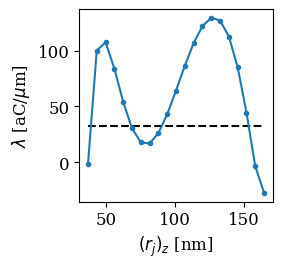

In [86]:
_ = linedensity(params3, obj3)

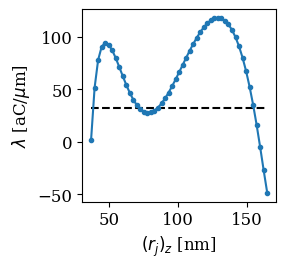

In [87]:
_ = linedensity(params4, obj4)

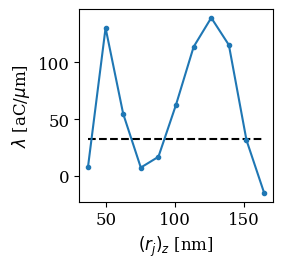

In [88]:
_ = linedensity(params5, obj5)

# Next steps

Computing the "best-fit" image charges is not a well-posed problem, at least for a cone.  To get a non-diverging charge distribution, I had to employ a large filtering factor $\alpha$.  The voltage errors are significant, on the order of five percent or more.  The total charge on the cone is not a sensitive function of the number of image-charge grid points. 

What to do next?

1. Reproduce Xu's calculation exactly. They published example matlab code. They had far fewer grid points than I did, and their image-charge locations inside the sphere were very thoughtfully chosen.  Using their approach could greatly decrease the number of image charges in the "fit".
2. Add a computation of capacitance derivatives.  Start with the sphere, where we can check results against analytical formulas.
3. Plot the capacitance versus height for the sphere-capped cone.  The cone's capacitance should decay more slowly than the sphere's.
4. Compute capacitance derivatives of the cone, where we can check against Hoepker's approximate formulas.
